In [1063]:
import pandas as pd
import numpy as np

In [1064]:
order = 20
states = 50
outputStates = 2
lookAhead = order-1
outputOrder = 7
lastPredictionAdj = lookAhead + outputOrder


transitionProbabilities = np.zeros((states, outputStates))

transitionCounts = np.zeros((states, outputStates))

transitionStateCounts = np.zeros(states)



In [1065]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [1066]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(0, length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSerie(timeSerie):
    avg = np.mean(timeSerie)
    var = np.var(timeSerie)
    if(var == 0):
        return np.zeros(timeSerie.shape)
    else:
        return (timeSerie - avg)/var

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
    return timeSeriesNorm




In [1067]:
from convertStockToJson import getJsonDataFromFile

def loadTimeSeriesNormalized(name, inputDuration, outputDuration):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    inputTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], inputDuration)
    outputTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], outputDuration)
    inputTimeSeriesNorm = normalizeTimeSeries(inputTimeSeries)
    outputTimeSeriesNorm = normalizeTimeSeries(outputTimeSeries)

    return (inputTimeSeriesNorm, outputTimeSeriesNorm, inputTimeSeries, outputTimeSeries, stockDatadf)


In [1176]:
stockNameTrainedOn = 'QAN'
(subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) = loadTimeSeriesNormalized(stockNameTrainedOn, order, outputOrder)


subTimeSeriesNorm = subTimeSeriesNorm[:-365]
outputTimeSeriesNorm = outputTimeSeriesNorm[:-365]


In [1177]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt




kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNorm)
cluserCenters = kmeans.cluster_centers_


# for cluster in cluserCenters:
   
#     plt.plot(cluster)
#     plt.show()






In [1178]:
maxChange = max(-np.min(cluserCenters), np.max(cluserCenters))
increaseData = np.linspace(-maxChange, maxChange, outputOrder)
mid = np.zeros(outputOrder)
decreaceData = np.linspace(maxChange, -maxChange, outputOrder)

dummyData = np.array([increaseData, decreaceData])


outputKMeans = KMeans(n_clusters=outputStates, random_state=0).fit(dummyData)
outputKMeans.cluster_centers_



array([[-233.00970874, -155.33980583,  -77.66990291,    0.        ,
          77.66990291,  155.33980583,  233.00970874],
       [ 233.00970874,  155.33980583,   77.66990291,    0.        ,
         -77.66990291, -155.33980583, -233.00970874]])

In [1179]:
outputsTransform = outputKMeans.transform(outputTimeSeriesNorm).transpose()
minOutPutTransform = np.min(outputsTransform, axis=1)
maxOutPutTransform = np.max(outputsTransform, axis=1)
print(minOutPutTransform)
print(maxOutPutTransform)

[212.93848541 198.63131025]
[1028.84636239 1251.38651227]


In [1180]:

buysOrSells = np.zeros(outputStates) 
buysOrSells[0] = 1
buysOrSells[1] = -1
# buysOrSells[2] = 0

In [1181]:
def predictStateVector(timeSerieNorm, kmeans):
    if len(kmeans.cluster_centers_) == outputStates:
        distances = kmeans.transform([timeSerieNorm])[0]
        return 1-(distances-minOutPutTransform)/(maxOutPutTransform-minOutPutTransform)
    else:
        distances = kmeans.transform([timeSerieNorm])[0]
        minDis = np.min(distances)
        maxDis = np.max(distances)
        distances -= minDis
        distances /= maxDis
        distances = 1 - distances
        distances = distances * distances * distances
        return distances


def predictStatesVector(timeSerieNorms, kmeans):
    result = np.zeros((timeSerieNorms.shape[0], len(kmeans.cluster_centers_)))
    for i in range(len(timeSerieNorms)):
        result[i] = predictStateVector(timeSerieNorms[i], kmeans)
    return result

    distances = kmeans.transform(timeSerieNorms)
    minDis = np.min(distances, axis=1)
    maxDis = np.max(distances, axis=1)
    for i in range(len(distances)):
        distances[i] -= minDis[i]
        distances[i] /= maxDis[i]
        distances[i] = 1 - distances[i]
        distances[i] = distances[i] * distances[i] * distances[i]
    return distances

def valuateOuput(timeSerieNorms):
    value = np.zeros(len(timeSerieNorms))
    for i in range(len(timeSerieNorms)):
        value[i] = timeSerieNorms[i][-1] - timeSerieNorms[i][0]
        
    return value

    

In [1182]:
print(predictStatesVector(outputTimeSeriesNorm, outputKMeans))

[[0.80880742 0.72459588]
 [0.614463   0.84628546]
 [0.59834196 0.89926622]
 ...
 [0.78194231 0.77716396]
 [0.78057328 0.77935402]
 [0.78100455 0.77907387]]


In [1183]:

def trainMarkokChain(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities

    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    subSeriesClassifified = kmeans.predict(subTimeSeriesNorm)
    outSeriesClassified = outputKMeans.predict(outTSNorm)

    for i in range(len(subSeriesClassifified)-lookAhead):
        currentState = subSeriesClassifified[i]
        nextState = outSeriesClassified[i+lookAhead]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1

def trainMarkokChainContinous(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)
    outputTSKMeanDistances = predictStatesVector(outTSNorm, outputKMeans)



    transitionCountsT = transitionCounts.transpose()
    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        nextState = outputTSKMeanDistances[i+lookAhead]
        for i in range(len(nextState)):
            adjust = currentState * nextState[i]
            transitionCountsT[i] += adjust
    transitionCounts = transitionCountsT.transpose()
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)

def trainMarkokChainContinousAlt(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)

    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        tsNorm = outTSNorm[i+lookAhead]
        dif = tsNorm[-1] - tsNorm[0]
        if(dif > 0):
            for j in range(len(currentState)):
                transitionCounts[j][0] += currentState[j] * dif
        else:
            for j in range(len(currentState)):
                transitionCounts[j][1] += currentState[j] * -dif
      
        
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)



trainMarkokChain(subTimeSeriesNorm, outputTimeSeriesNorm)
#trainMarkokChainContinous(subTimeSeriesNorm, outputTimeSeriesNorm)
#trainMarkokChainContinousAlt(subTimeSeriesNorm, outputTimeSeriesNorm)

print(transitionCounts)
print(transitionStateCounts)

[[  1.   0.]
 [ 33.  22.]
 [ 94.  63.]
 [  7.   6.]
 [ 31.  27.]
 [ 44.  41.]
 [  3.   5.]
 [ 11.   0.]
 [  0.   1.]
 [ 18.   9.]
 [ 96. 108.]
 [  1.   0.]
 [  0.   1.]
 [  9.   4.]
 [  0.   1.]
 [  1.   0.]
 [ 25.  31.]
 [ 19.  15.]
 [  0.   1.]
 [ 15.   9.]
 [  4.   0.]
 [  0.   1.]
 [ 21.  20.]
 [  0.   1.]
 [  0.   1.]
 [  6.  13.]
 [  9.  19.]
 [  0.   1.]
 [  1.   0.]
 [ 12.   2.]
 [  2.   0.]
 [ 29.  23.]
 [  1.   0.]
 [  1.   0.]
 [ 41.  41.]
 [  1.   0.]
 [  2.   0.]
 [  1.   0.]
 [  1.   0.]
 [  3.   3.]
 [  0.   1.]
 [  0.   1.]
 [131.  85.]
 [  1.   0.]
 [  1.   0.]
 [  1.   0.]
 [  1.   0.]
 [  8.   4.]
 [  4.   2.]
 [ 59.  47.]]
[  1.  55. 157.  13.  58.  85.   8.  11.   1.  27. 204.   1.   1.  13.
   1.   1.  56.  34.   1.  24.   4.   1.  41.   1.   1.  19.  28.   1.
   1.  14.   2.  52.   1.   1.  82.   1.   2.   1.   1.   6.   1.   1.
 216.   1.   1.   1.   1.  12.   6. 106.]


In [1184]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)

[[1.         0.        ]
 [0.6        0.4       ]
 [0.59872611 0.40127389]
 [0.53846154 0.46153846]
 [0.53448276 0.46551724]
 [0.51764706 0.48235294]
 [0.375      0.625     ]
 [1.         0.        ]
 [0.         1.        ]
 [0.66666667 0.33333333]
 [0.47058824 0.52941176]
 [1.         0.        ]
 [0.         1.        ]
 [0.69230769 0.30769231]
 [0.         1.        ]
 [1.         0.        ]
 [0.44642857 0.55357143]
 [0.55882353 0.44117647]
 [0.         1.        ]
 [0.625      0.375     ]
 [1.         0.        ]
 [0.         1.        ]
 [0.51219512 0.48780488]
 [0.         1.        ]
 [0.         1.        ]
 [0.31578947 0.68421053]
 [0.32142857 0.67857143]
 [0.         1.        ]
 [1.         0.        ]
 [0.85714286 0.14285714]
 [1.         0.        ]
 [0.55769231 0.44230769]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5        0.5       ]


def loadTimeSeriesClassified(name, inputDuration, outputDuration):
    normalized = loadTimeSeriesNormalized(name, inputDuration, outputDuration)
    return (normalized, True)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

def testMarkovChain(subSeriesClassifified, outTSNorm):
    numCorrect = 0
    length = len(subSeriesClassifified)-lookAhead
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = outTSNorm[i+lookAhead]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO', 'ANZ']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    ((inputTS, outPutTs), success) = loadTimeSeriesClassified(fileName, order, outputOrder)  
    if(success):  
        percetage = testMarkovChain(inputTS, outPutTs)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


In [1185]:

def shouldBuyorSells(timeSeries):
    timeSerieNorms = normalizeTimeSeries(timeSeries)
    rankings = predictStatesVector(timeSerieNorms, kmeans)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells))



def shoudlBuyorSell(timeSerie):
    distinct = False
    if distinct :
        currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        nextState = np.argmax(transitionProbabilities[currentState])
        return buysOrSells[nextState]
    else:
        #currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        timeSerieNorm = normalizeTimeSeries(np.array([timeSerie]))[0]
        rankings = predictStateVector(timeSerieNorm, kmeans)
        return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells) )


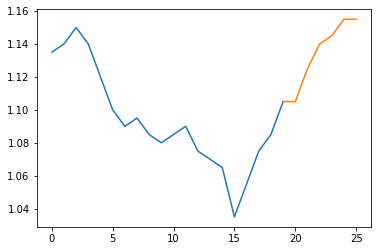

3.7640604013314345
[[285.19362769 539.98192805]]
[0.91144203 0.67575499]


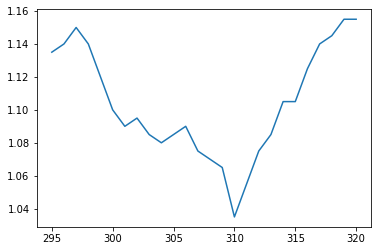

In [1186]:
def plotSample():
    (subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) = loadTimeSeriesNormalized(stockNameTrainedOn, order, outputOrder)
    i = 295
    sample = subTimeSeries[i]
    sampleNorm = subTimeSeriesNorm[i]
    answer = outputTimeSeries[i+lookAhead]
    answerNorm = outputTimeSeriesNorm[i+lookAhead]
    plt.plot(np.arange(len(sample)),sample)
    plt.plot(np.arange(lookAhead, lookAhead+len(answer)),answer)
    plt.show()
    print(shoudlBuyorSell(sampleNorm))
   #print(outputKMeans.predit([normalizeTimeSerie(answer)]))
    print(outputKMeans.transform([answerNorm]))
    print(predictStateVector(answerNorm, outputKMeans))

    plt.plot(stockDatadf['Close'][i:i+lookAhead+outputOrder])
    plt.show()
plotSample()

In [1187]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False
        
        if(daysShouldWaitToSell == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    daysShouldWaitToSell = outputOrder
                    didBuy = True


        elif(daysShouldWaitToSell == 0):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                daysShouldWaitToSell = None
                didSell = True
        else:
            daysShouldWaitToSell -= 1
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


In [1188]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor)-1 if boughtFor!=None else None

        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


In [1189]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03
    sellThreshold = 0

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor) - 1 if boughtFor!=None else None
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss or sellThreshold > signal):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower

In [1190]:
def thresholdRange(subTimeSeries, steps = 20):
    signals = np.ndarray((len(subTimeSeries)))
   
    for i in range(len(subTimeSeries)):
        signals[i] = shoudlBuyorSell(subTimeSeries[i])
    
    minSig = np.min(signals)
    maxSig = np.max(signals)
    print(minSig)
    print(maxSig)
    if(minSig == maxSig):
        return [minSig]
    else:
        return np.arange(minSig, maxSig, (maxSig-minSig)/steps)



In [1191]:

stockPriceHistory = jsonToDataFrame(getJsonDataFromFile(stockNameTrainedOn))['Close']

subTimeSeries = convertArrayToTimeSeries(stockPriceHistory, order)[len(subTimeSeriesNorm):]


In [1192]:


bestthreshold = -np.inf
bestPrice = -np.inf
for threshold in thresholdRange(subTimeSeries):
    price = runModelAgainst(subTimeSeries, threshold)
    if(bestPrice < price):
        bestPrice = price
        bestthreshold = threshold
    print((price, threshold))

3.159836888899287
5.400986333641779
(943.0000000000006, 3.159836888899287)
(987.6900000000002, 3.2718943611364115)
(941.8700000000006, 3.383951833373536)
(1160.26, 3.4960093056106607)
(1116.3899999999999, 3.6080667778477853)
(1154.66, 3.72012425008491)
(1171.2200000000005, 3.8321817223220345)
(1145.0800000000004, 3.944239194559159)
(1128.96, 4.056296666796284)
(1197.9600000000007, 4.168354139033408)
(1055.4800000000002, 4.280411611270533)
(834.5000000000003, 4.392469083507658)
(857.6900000000002, 4.504526555744782)
(928.3100000000001, 4.616584027981906)
(939.1100000000001, 4.728641500219031)
(892.9200000000002, 4.840698972456156)
(891.4500000000002, 4.95275644469328)
(926.55, 5.0648139169304045)
(926.55, 5.1768713891675295)
(962.25, 5.288928861404655)


In [1193]:

def trackModel(threshold):
    equity = np.zeros(len(subTimeSeries))
    monies = np.zeros(len(subTimeSeries))
    stockOverTime = np.zeros(len(subTimeSeries))
    buys = []
    hasBuys = [False]
    sells = []
    hasSells = [False]
    stockPrices = []
    signals = []
    def record(state):
        (i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal) = state
        buys.append(stockPrice if didBuy else None)
        sells.append(stockPrice if didSell else None)
        if(didBuy):
            hasBuys[0] = True
        if(didSell):
            hasSells[0] = True
        stockPrices.append(stockPrice)
        signals.append(signal)
        equity[i] = buyingPower + stocks*stockPrice
        monies[i] = buyingPower
        stockOverTime[i] = stocks*stockPrice

    runModelAgainst(subTimeSeries, threshold, record)

    plt.plot(equity)
    plt.xlabel('Time (days)')
    plt.ylabel('Equity ($)')
    plt.show()

    plt.plot(monies, c='blue')
    plt.plot(stockOverTime, c='red')
    plt.show()

    fig,ax = plt.subplots()
    ax.plot(stockPrices)
    ax.set_ylabel("Stock Price ($)")
    ax.set_xlabel("Time (days)")
    if(hasBuys[0]):
        ax.scatter(np.arange(len(buys)), buys, c='green')
    if(hasSells[0]):
        ax.scatter(np.arange(len(sells)), sells, c='red')
    ax2=ax.twinx()
    ax2.plot(signals,c='black', alpha=0.2)
    ax2.plot([0, len(signals)-1], [threshold, threshold], c='red', alpha=0.2)
    ax2.set_ylabel('Signal, Future Prediction')
    fig.show()
    plt.show()

    plt.plot(signals)
    plt.show()

3.159836888899287
5.400986333641779
5.027461426184697


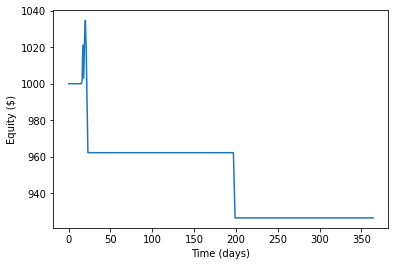

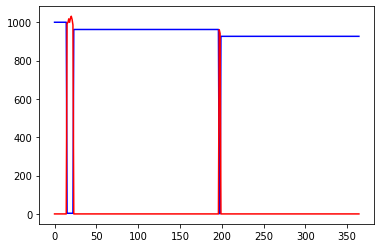

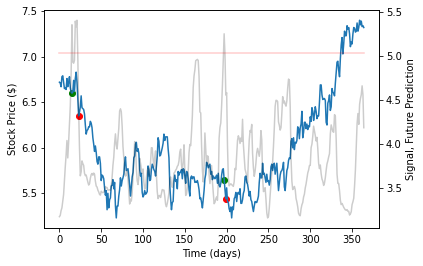

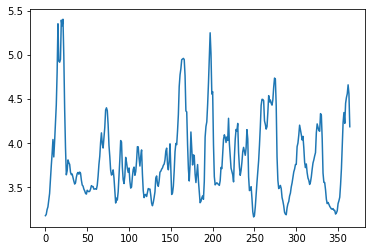

4.653936518727615


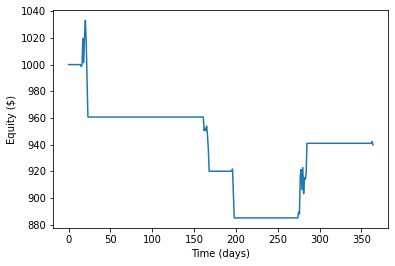

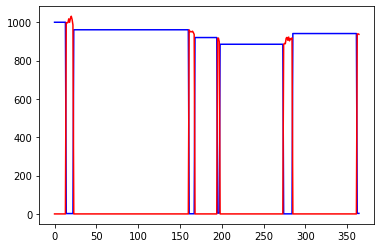

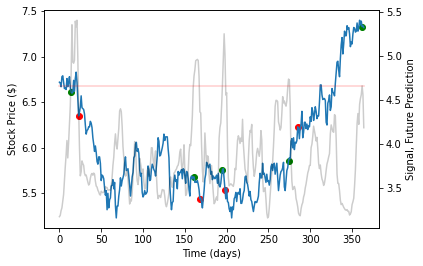

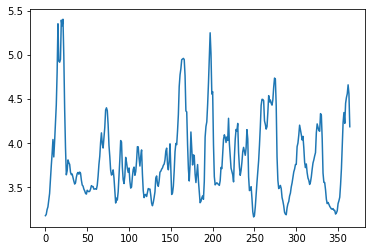

4.280411611270534


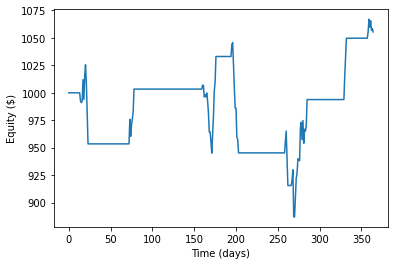

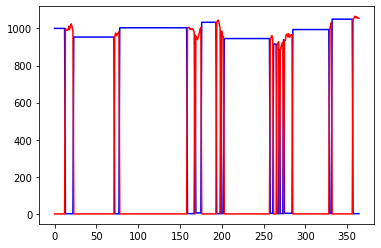

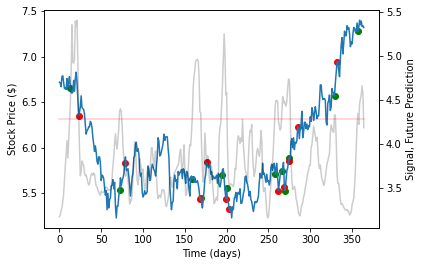

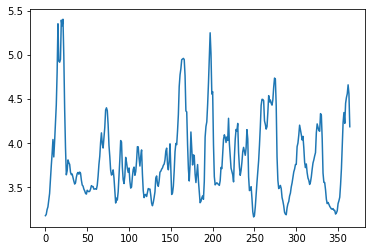

3.906886703813451


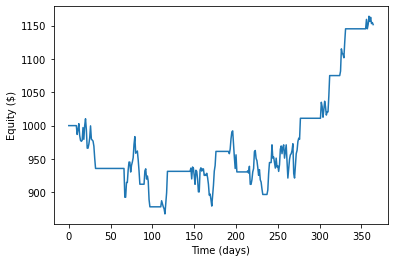

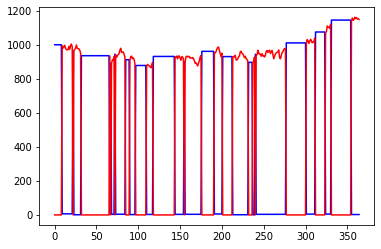

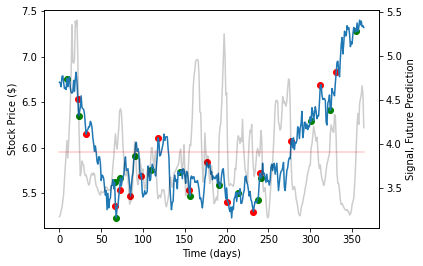

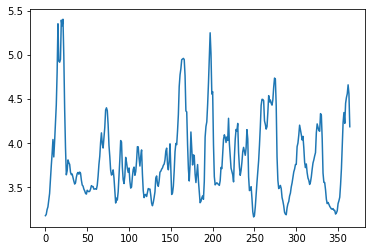

3.533361796356369


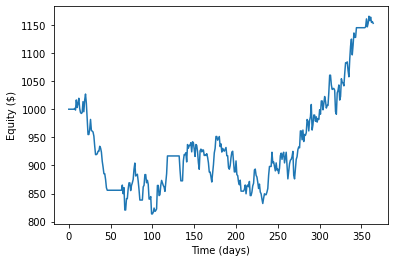

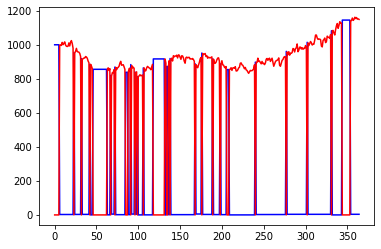

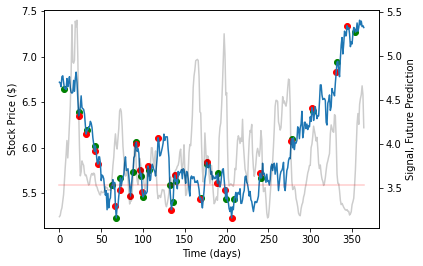

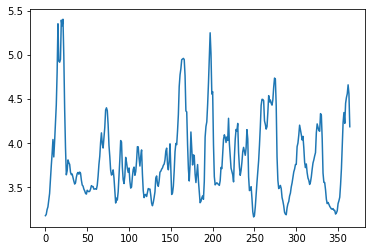

3.159836888899287


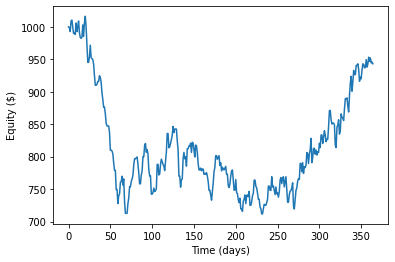

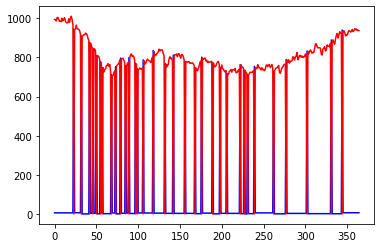

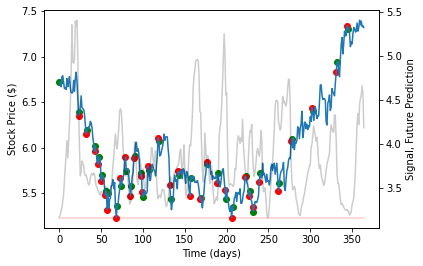

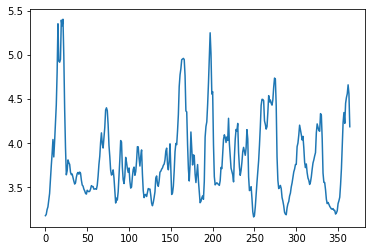

In [1194]:
for threshold in thresholdRange(subTimeSeries, 6)[::-1]:
    print(threshold)
    trackModel(threshold)

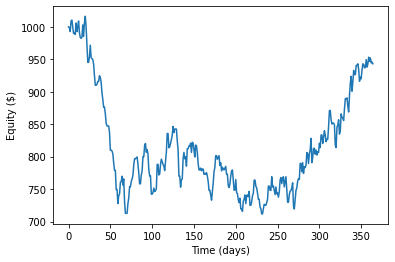

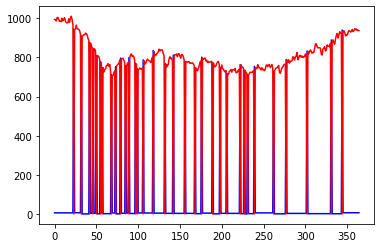

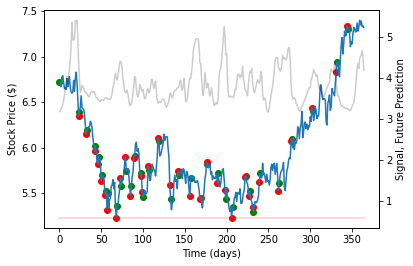

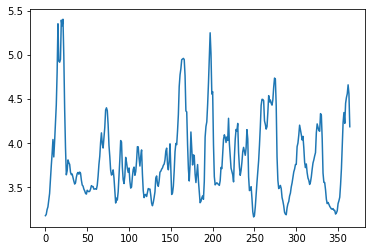

In [1195]:
trackModel(0.58)

3.159836888899287
5.400986333641779


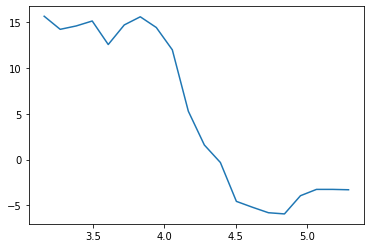

In [1196]:
def effectivity(threshold):
    buys = []
    sells = []
    stockPrices = []
    signals = []
    profits = []

    for i in range(len(subTimeSeries) - lastPredictionAdj):
        stockPrice = subTimeSeries[i][-1]
        stockPriceFuture = subTimeSeries[i+lastPredictionAdj][-1]
        signal = shoudlBuyorSell(subTimeSeries[i])

        buys.append(None)
        sells.append(None)
        stockPrices.append(stockPrice)
        signals.append(signal)
        profits.append(0)
        if(signal > threshold):
            #buy
            buys[i] = stockPrice  
            profit = stockPriceFuture - stockPrice
            profits[i] = profit


    return np.sum(profits)


profits = []
thresholds = []
for threshold in thresholdRange(subTimeSeries, 20)[::-1]:
    profits.append(effectivity(threshold))
    thresholds.append(threshold)

plt.plot(thresholds, profits)
plt.show()